In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy
import os
import cv2
from PIL import Image
import numpy as np

In [2]:
image_directory = 'Dataset_Phase1/'
size = 224
dataset = []
label = []

pneumothorax_images = os.listdir(image_directory + 'Pneumothorax/')
for i, image_name in enumerate(pneumothorax_images):
    image = cv2.imread(image_directory + 'Pneumothorax/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir(image_directory + 'Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread(image_directory + 'Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)
X_train = X_train/255.
X_test = X_test/255.

In [4]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
def get_model(input_shape=(224,224,3)):
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in vgg.layers[:-8]:
        print(layer.name)
        layer.trainable=False
        
    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    
    model = Model(vgg.input, x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
model = get_model(input_shape=(224,224,3))
print(model.summary())
history = model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=1, validation_data=(X_test,y_test))

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1

KeyboardInterrupt: 

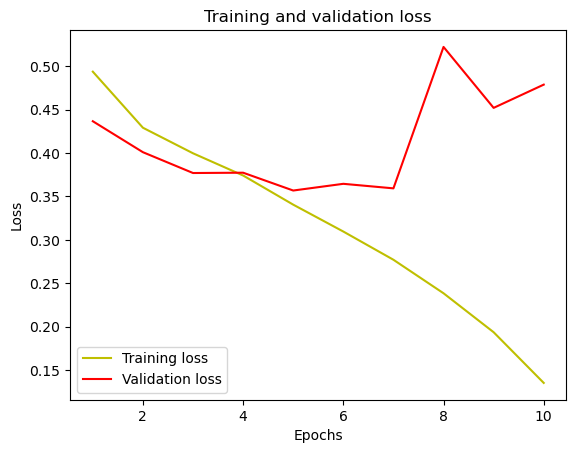

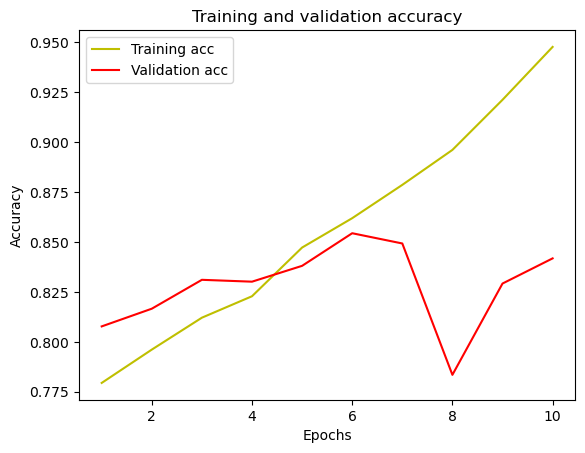

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
_,train_acc = model.evaluate(X_train, y_train)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model.evaluate(X_test, y_test)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

268/268 [==============================] - 609s 2s/step - loss: 0.0670 - accuracy: 0.9791
Accuracy of train datasets =  97.91107773780823 %
67/67 [==============================] - 147s 2s/step - loss: 0.4788 - accuracy: 0.8418
Accuracy of valid datasets =  84.18105244636536 %


The prediction for this image is:  1
The actual label for this image is:  1


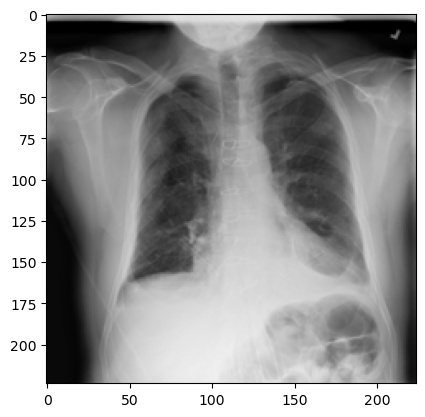

In [15]:
n=123
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

<AxesSubplot:>

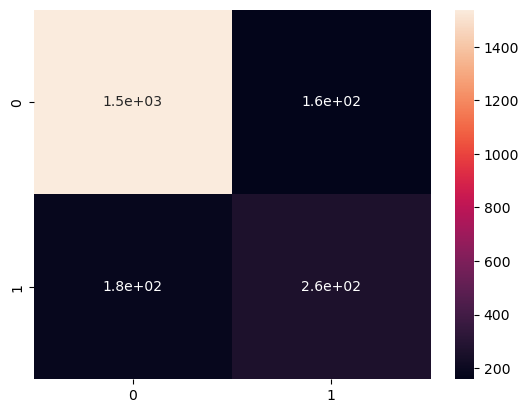

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)

In [17]:
pneumothorax_images_idx = np.where(y_pred == 1)[0]

In [18]:
predicted_as_para = []
for i in pneumothorax_images_idx:
    pneu_img = X_test[i]
    predicted_as_para.append(pneu_img)
    
predicted_as_para = np.array(predicted_as_para)

In [1]:
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max

def plot_heatmap(img):
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    last_layer_weights = model.layers[-1].get_weights()[0]
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    last_conv_model = Model(model.input, model.get_layer("block4_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    heat_map[img[:,:,0] == 0] = 0 
     
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


0
1
2
3


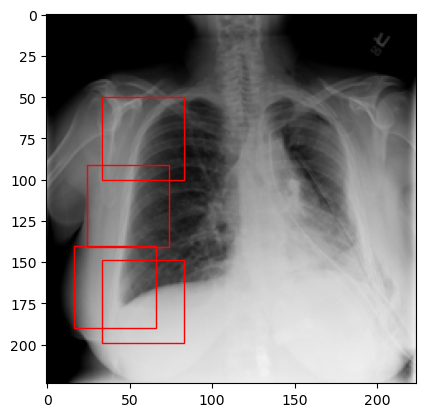

In [24]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])

In [25]:
model.save('vgg16_model.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pneumothorax_CAD\assets


In [ ]:
from keras.models import load_model

loaded_model = load_model('vgg16_model.h5')